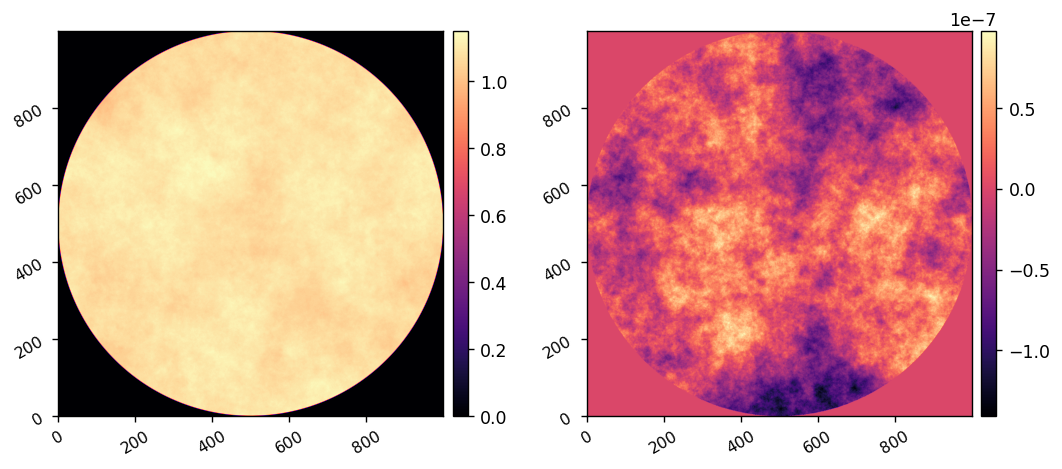

In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import efc_1dm as efc
import adefc_vortex.pwp as pwp
import adefc_vortex.scoob_model as scoobm

wavelength_c = 633e-9

wfe_amp = utils.load_fits('data/example_wfe_amp.fits')
wfe_opd = utils.load_fits('data/example_wfe_opd.fits')
imshow2(wfe_amp, wfe_opd)


# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


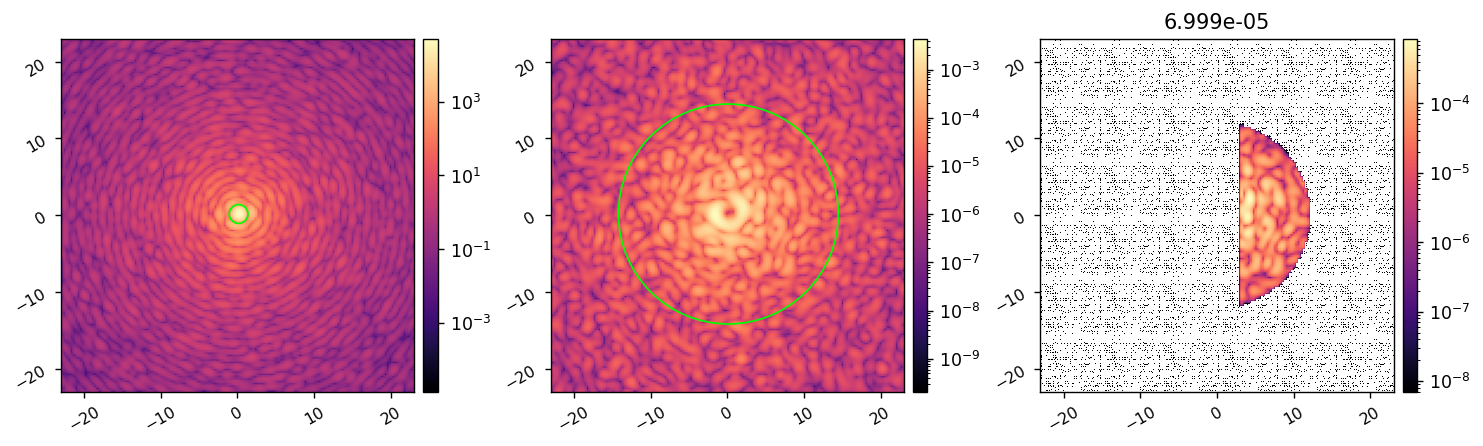

In [3]:
reload(scoobm)
I = scoobm.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
I.AMP = wfe_amp
I.OPD = wfe_opd

I.reverse_lyot = 1
I.flip_lyot = 1
# I.det_rotation = 178

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 3
owa = 12
rot = 0
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamDc/2, I.psf_pixelscale_lamDc/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamDc, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')],
        )

In [22]:
M.oversample

2.048

Oversampling > 2x suggested for reliable results in Fresnel propagation.


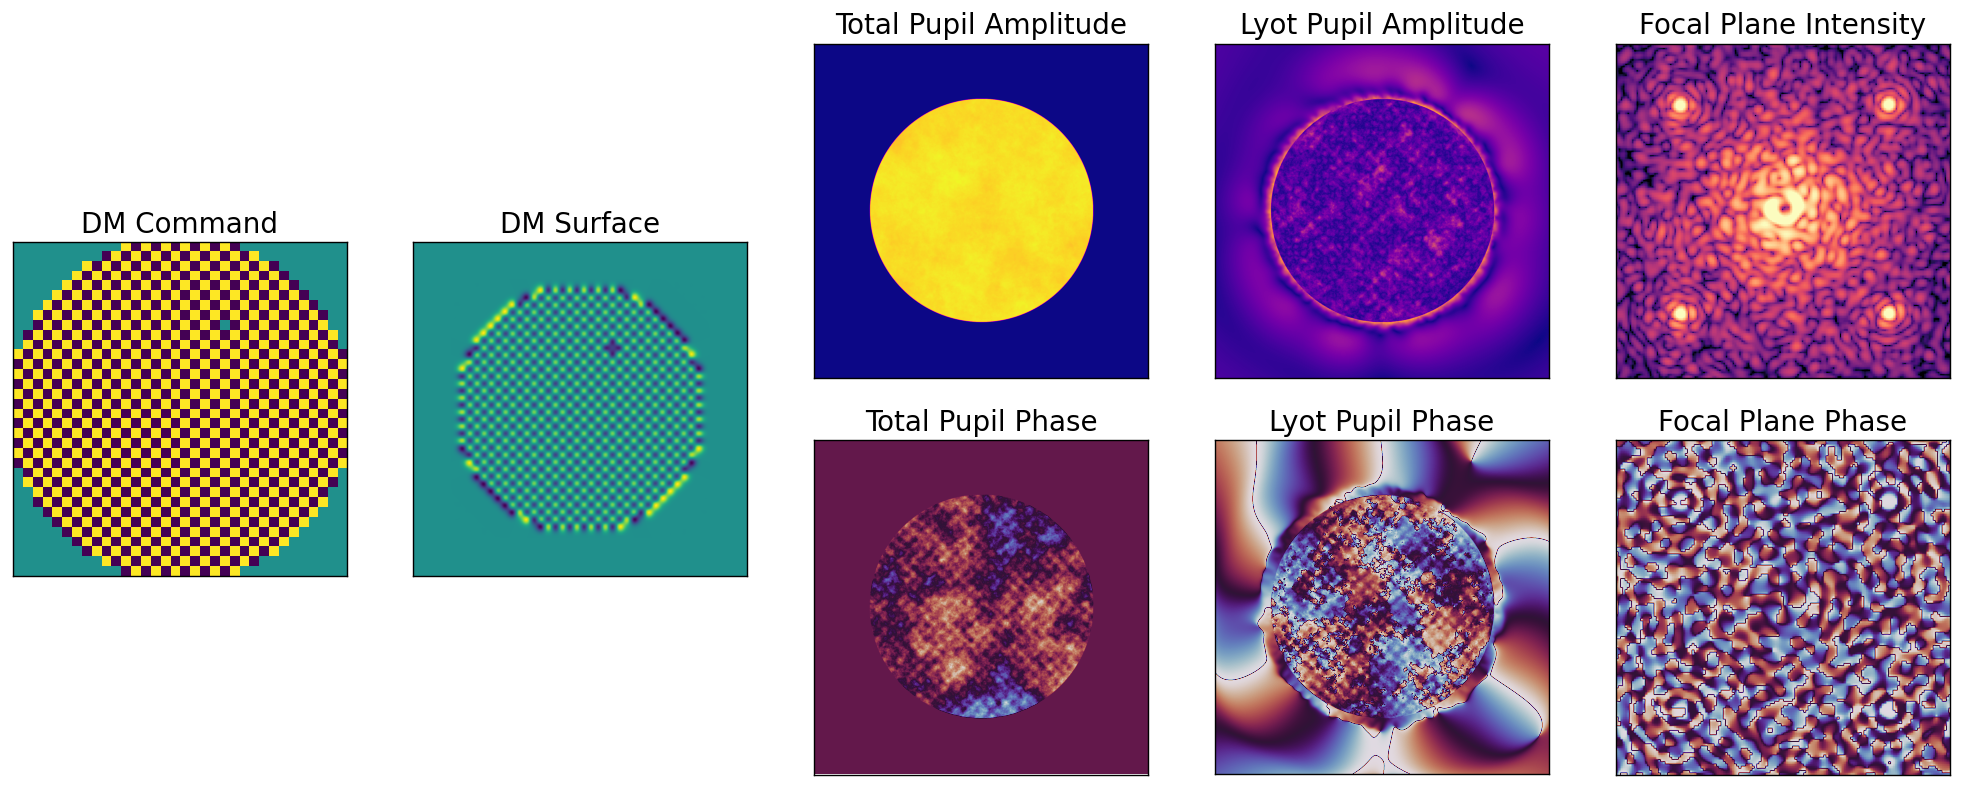

In [4]:
reload(scoobm)
reload(utils)
M = scoobm.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    dm_shift=np.array([0,0])*u.mm,
    # lyot_shift=np.array([0,0.3])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

M.reverse_lyot = 1
M.flip_lyot = 1
# M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

command = np.zeros((M.Nact, M.Nact))
command = 50e-9*utils.make_f(h=10, w=6, shift=(0,0))
command = 20e-9*utils.make_fourier_command(x_cpa=17, y_cpa=17)
# fpwf = M.forward(acts, use_vortex=0, plot=True)
fpwf = M.forward(command[M.dm_mask], use_vortex=1, plot=0, fancy_plot=1)



In [8]:
reload(efc)

jac = efc.compute_jacobian(
    M, 
    control_mask, 
    amp=1e-9, 
    current_acts=None, 
    wavelength=I.wavelength_c,
)

(3252, 951)


In [9]:
cm15 = utils.beta_reg(jac, -1.5)
cm20 = utils.beta_reg(jac, -2.0)
cm25 = utils.beta_reg(jac, -2.5)
cm30 = utils.beta_reg(jac, -3.0)
cm35 = utils.beta_reg(jac, -3.5)
cm40 = utils.beta_reg(jac, -4.0)
cm45 = utils.beta_reg(jac, -4.5)
cm50 = utils.beta_reg(jac, -5.0)

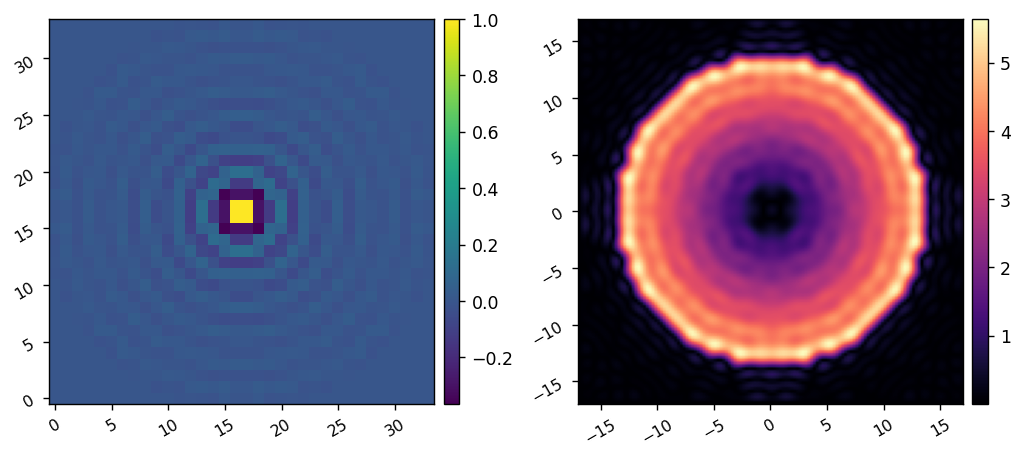

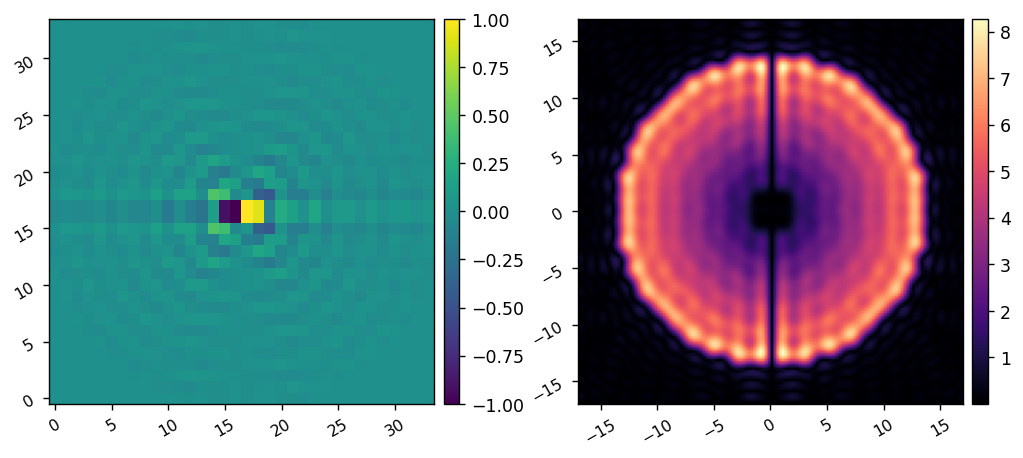

In [10]:
reload(utils)
fourier_probes = utils.create_fourier_probes(
    I.dm_mask, I.npsf, I.psf_pixelscale_lamDc, 
    iwa-0.5, owa+1, 
    # edge=iwa-0.5,
    fourier_sampling=0.75, 
    nprobes=2,
    plot=True,
    use_weighting=True
)

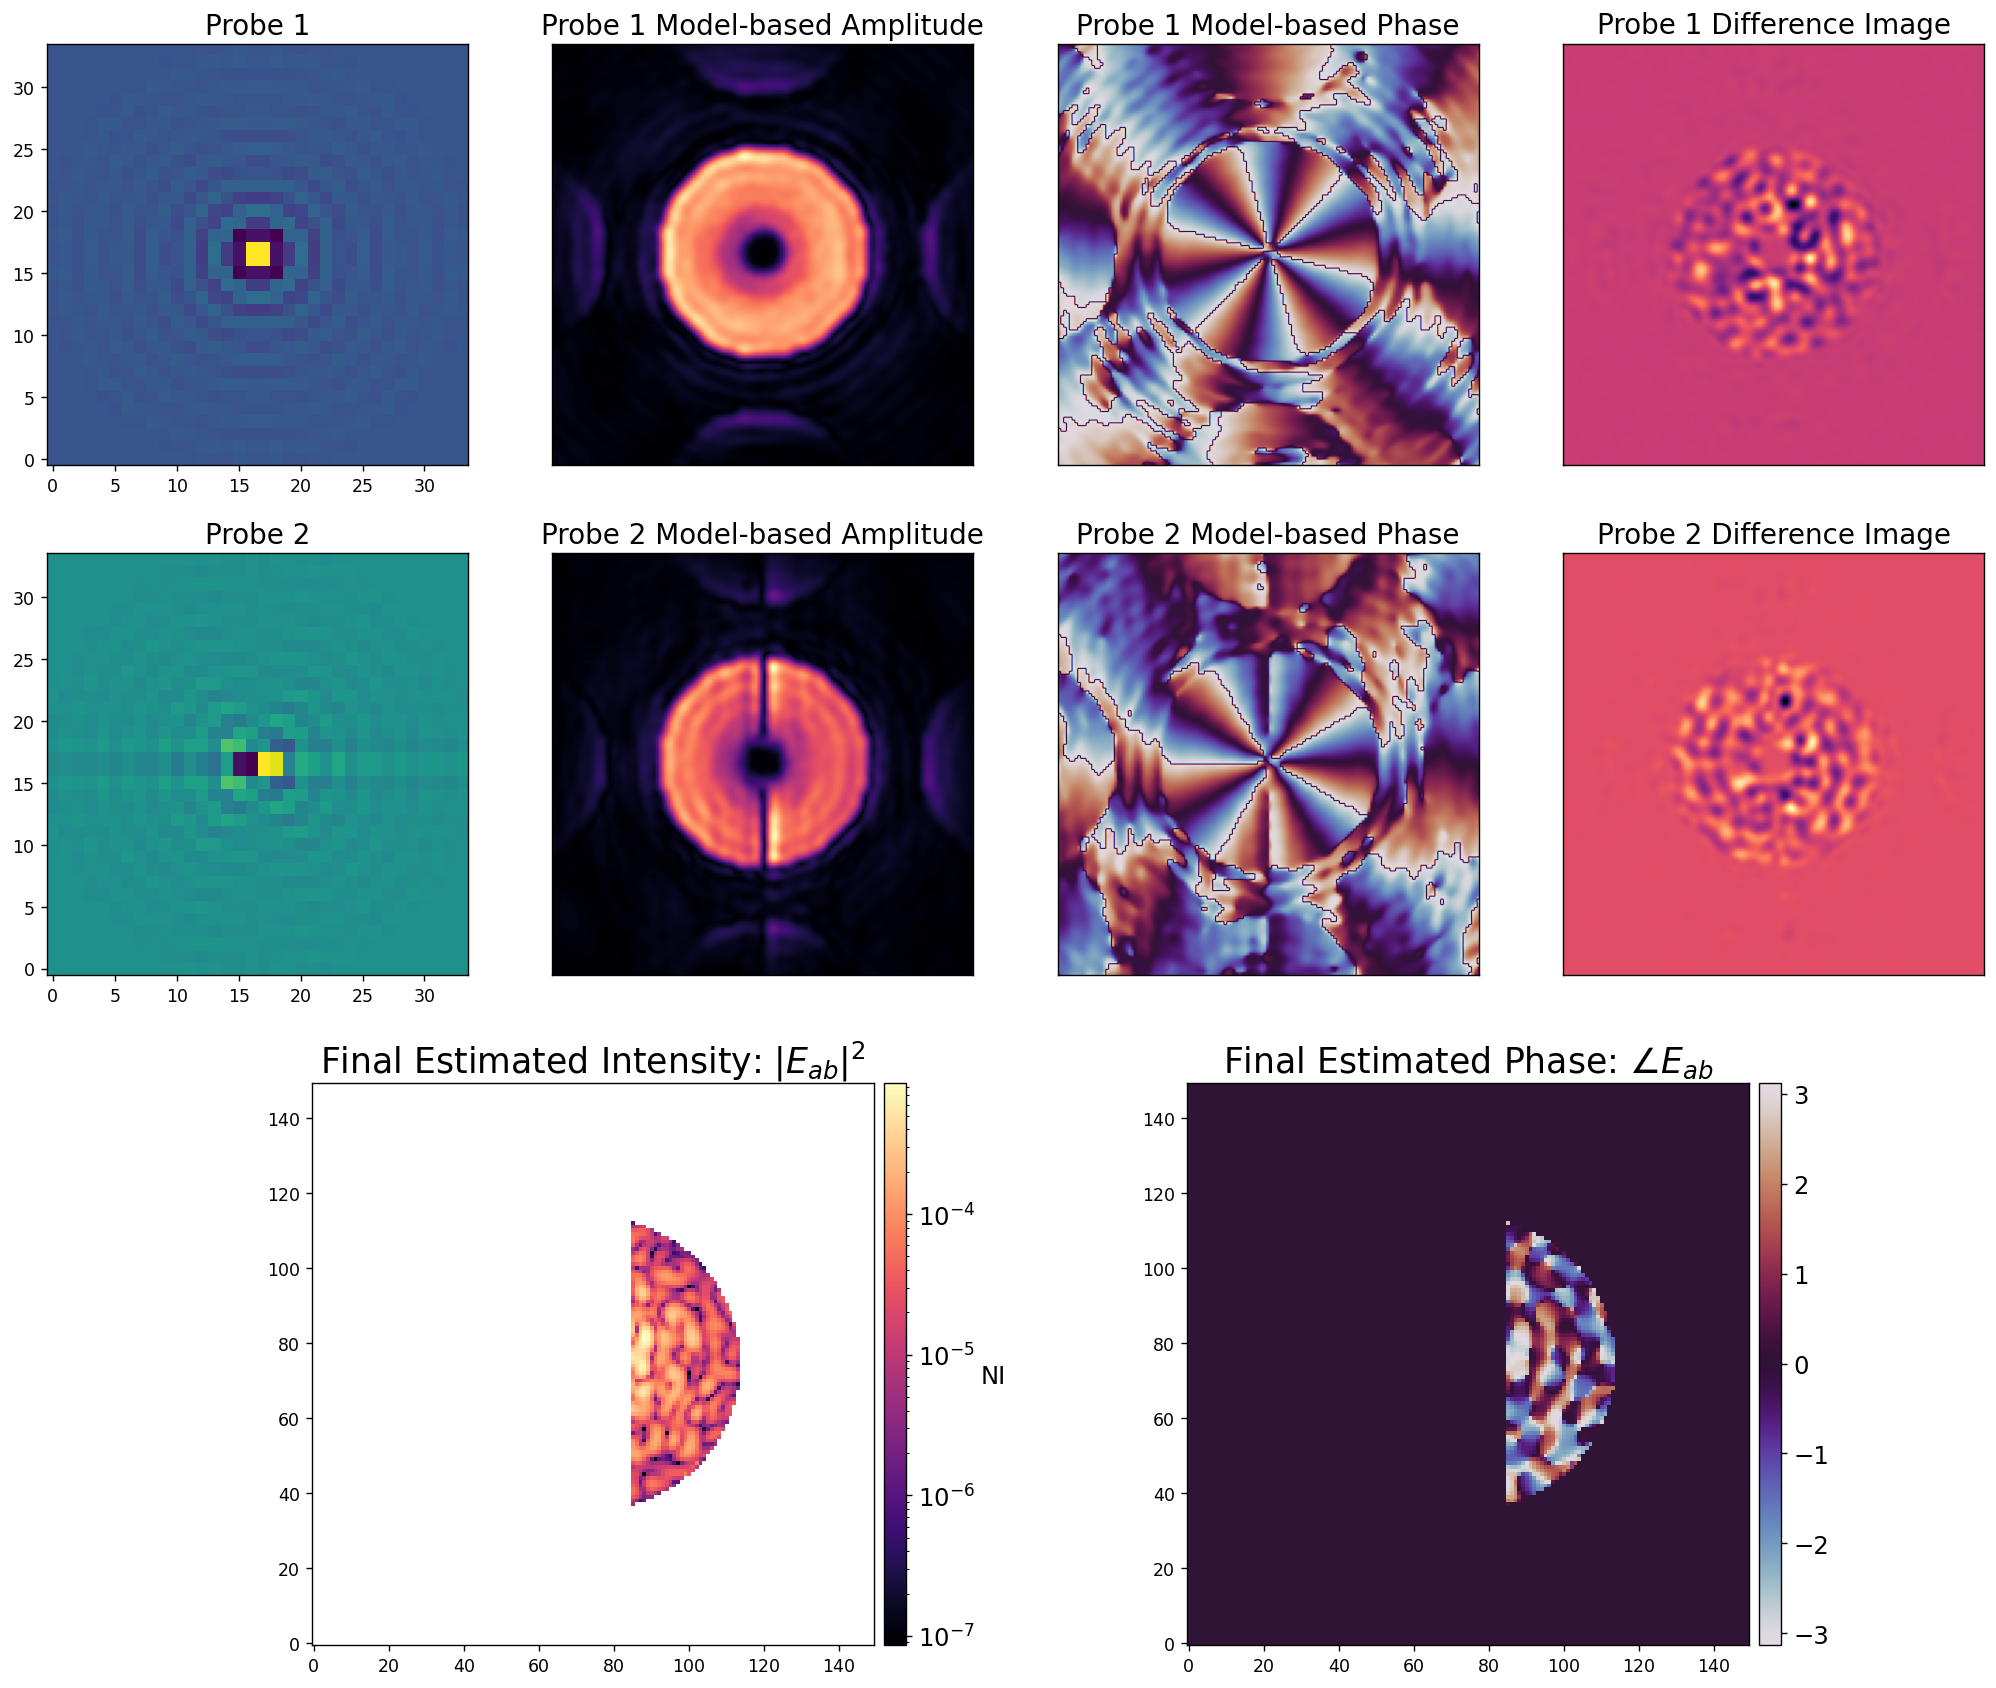

In [6]:
reload(pwp)

current_acts = xp.zeros(I.Nacts)

I.set_dm(scoobm.acts_to_command(current_acts, I.dm_mask))
E_pwp, E_probes, diff_ims = pwp.run(
    I, 
    M, 
    control_mask, 
    fourier_probes, 
    2.5e-9, 
    I.wavelength_c,
    plot=True,
    # plot_est=True,
    Ndms=1,
    return_all=True,
    # plot_fname='../figs/pwp_example.pdf',
)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

In [18]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Running PWP ...


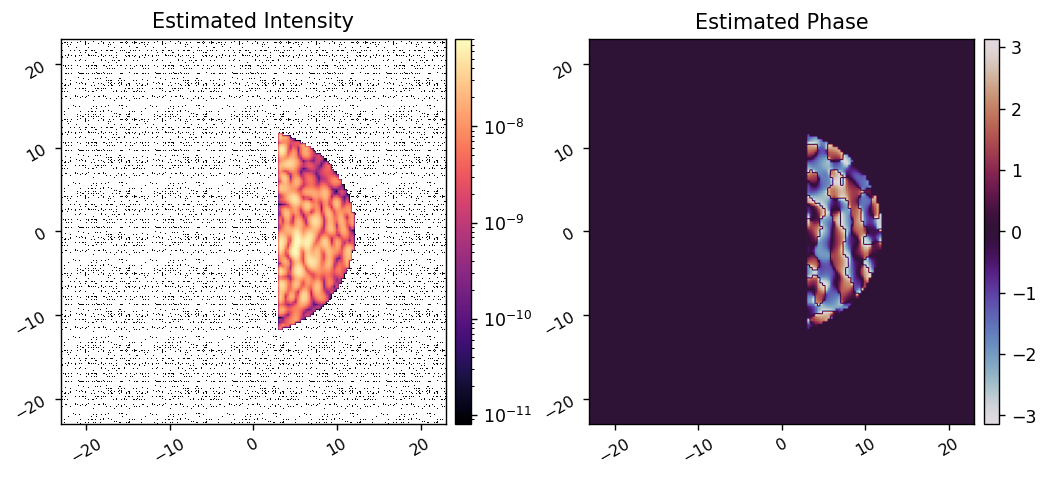

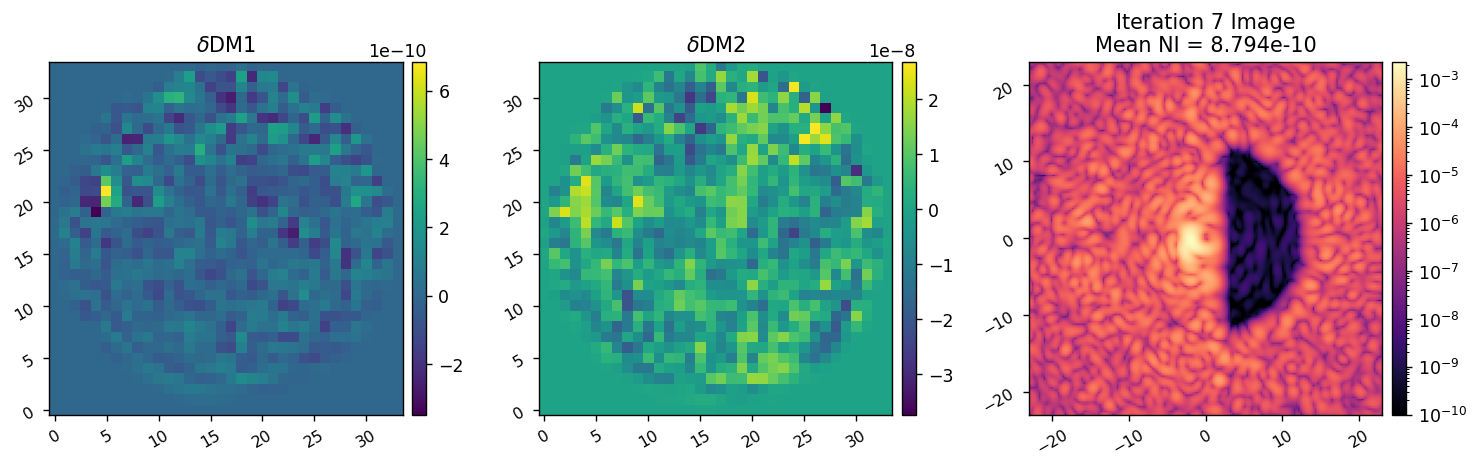

Running PWP ...


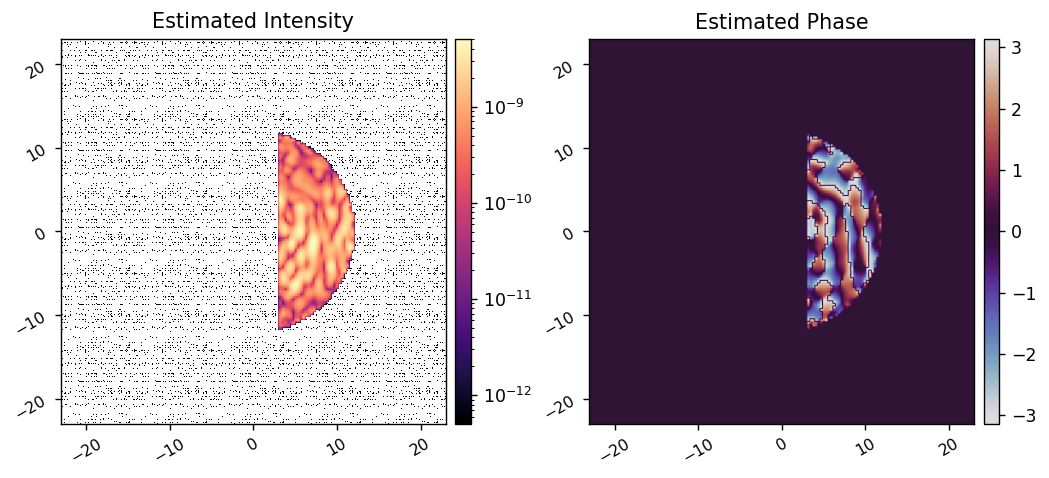

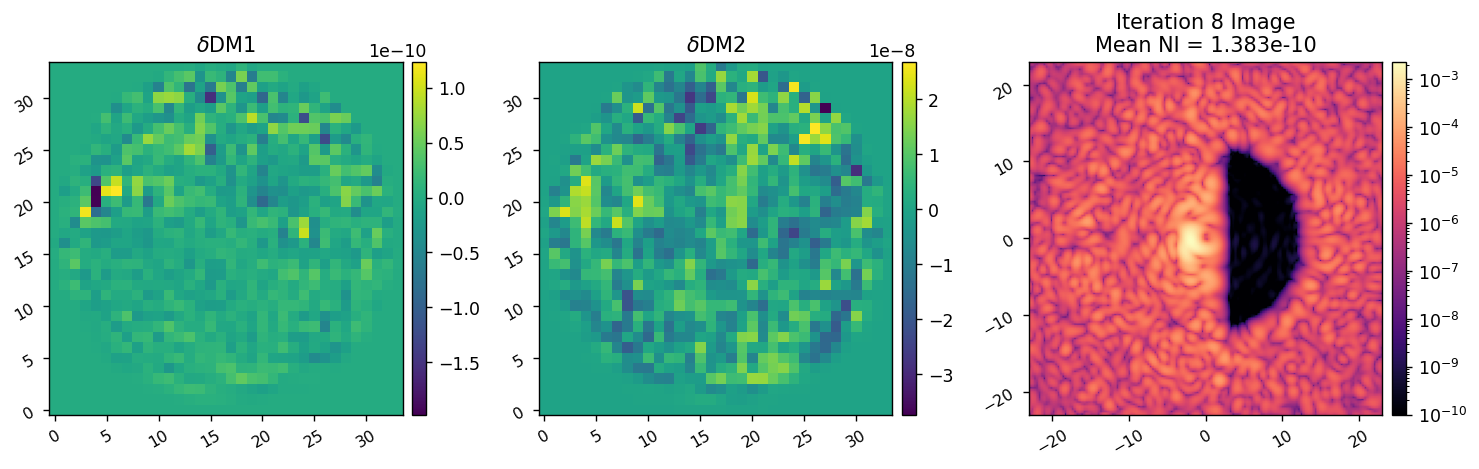

Running PWP ...


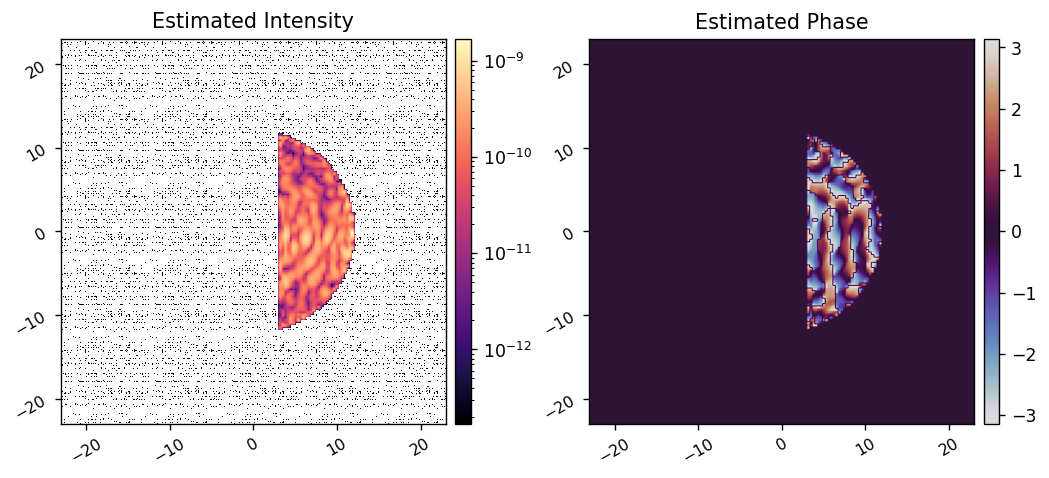

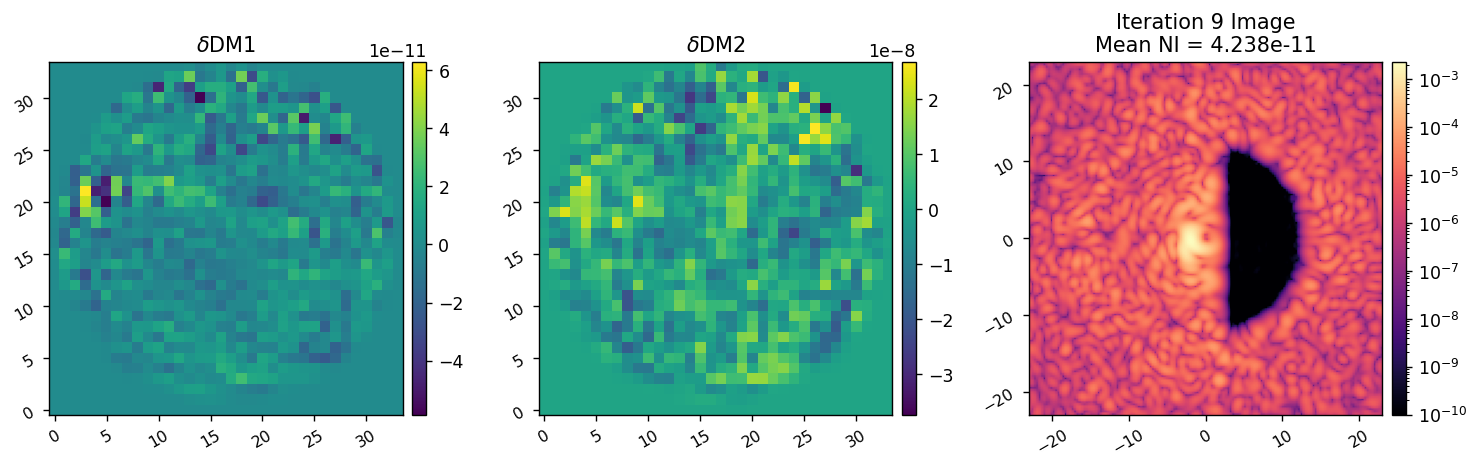

In [21]:
reload(scoobm)
reload(efc)
reload(utils)

pwp_params = {
    'M':M,
    'control_mask':control_mask, 
    'probes':fourier_probes,
    # 'probe_amp':2.5e-9,
    # 'probe_amp':1.5e-9,
    'probe_amp':0.5e-9,
    'wavelength':I.wavelength_c,
    'reg_cond':1e-2,
    # 'reg_cond':1e-3,
    # 'reg_cond':1e-4,
    'Ndms':1,
    # 'plot':True,
    'plot_est':True, 
}

data = efc.run(
    I, 
    # cm15, 
    # cm20,
    cm25,
    # cm30,
    # cm35,
    # cm40,
    # cm45,
    # cm50,
    control_mask, 
    data,
    pwp_params=pwp_params,
    Nitr=3, 
    gain=1,
)


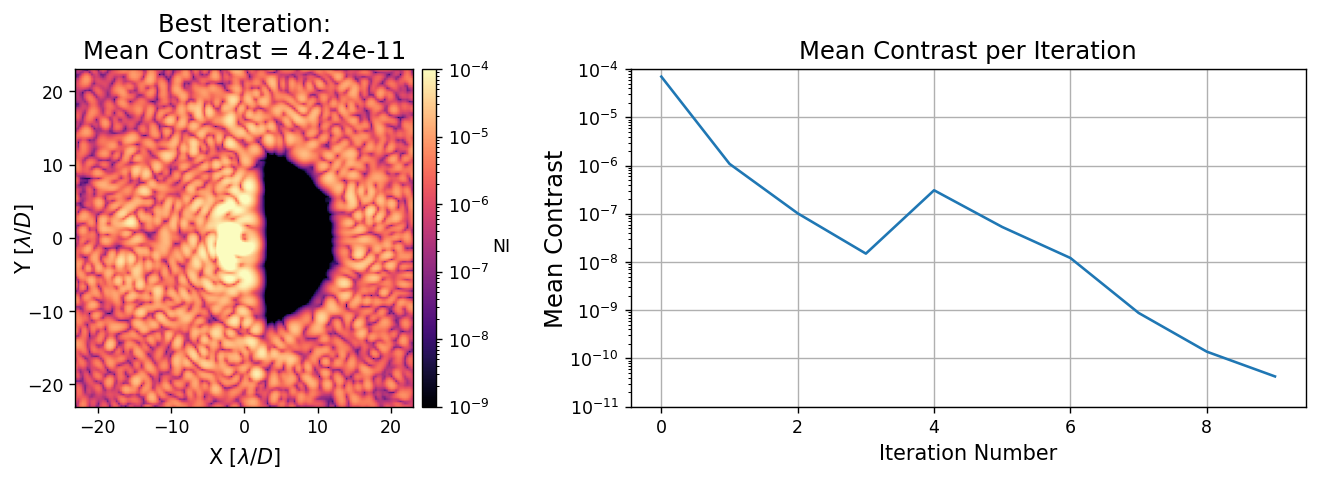

In [23]:
from adefc_vortex.imshows import plot_data
plot_data(data, vmin=1e-11, vmax=1e-4)

In [26]:
print(xp.array(data['commands'])[:,25,21])

[0. 0. 0. 0. 0. 0.]
